<a href="https://colab.research.google.com/github/Mbonea-Mjema/Sudoku-Solver-Machine-vision/blob/master/sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#To do list
# - install the required modules
# - find the grid
# - get the grid values
# - put the values in a matrix of somesort
# - solve the sudoku puzzle
# - write the answers you got




# Install the required modules

In [0]:
!sudo apt-get install aria2c

## **Download the required files**

In [0]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg/1200px-Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg.png -O sudoku.png
#!wget -qO- http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz | tar zxvf -
#!wget http://pi.math.cornell.edu/~mec/Summer2009/meerkamp/Site/Introduction_files/intro.png -O sudoku.png

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# **Deep Neural Networks Part**

Create training and testing data with labels


In [164]:
#create our sampling data and labels
import os
import cv2
from numpy import zeros
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


def folder_number(num):
  return str(num).zfill(3)
folders="/content/English/Fnt/Sample{}"

count =0 # counting variable
height =28
width =28
image_count  = 1016*10 #number of images
dim  = image_count,height,width #dimension of numpy array

# create numpy array to store all the data
all_images=zeros(dim,dtype='uint8') 
all_labels = zeros((image_count,),dtype='uint8')


# loop through the images
for i in range(1,11,1):
  current_dir = folders.format(folder_number(i))
  for image in os.listdir(current_dir):
    image = os.path.join(current_dir,image) # get the image path

    image_array=cv2.imread(image) #read the image (converts it into a matrix)
    gray = cv2.cvtColor(image_array,cv2.COLOR_BGRA2GRAY) # convert the image to grayscale
    small=cv2.resize(gray,(28,28))  # converts it into a 28 x 28 matrix
    all_images[count]=small    # add the image to the image array
    all_labels[count]=i-1      # add the lable of the image to the array
    count+=1

#randomize the two numpy arrays the same way
random_order = np.arange(all_images.shape[0])
np.random.shuffle(random_order)
all_images=all_images[random_order]
all_labels=all_labels[random_order]

cv2_imshow(all_images[100])
print(all_labels[100])

train = int(all_images.shape[0]*.8)
train_images = all_images[:train]
train_labels =all_labels[:train]

test_images = all_images[train+1:]
test_labels =all_labels[train+1:]


# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

# Build the model.
model = Sequential([
  Dense(16, activation='relu', input_shape=(784,)),
  Dense(16, activation='relu'),
  Dense(10, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=5,
  batch_size=32,
)

model.evaluate(
  test_images,
  to_categorical(test_labels)
)

#save the model
model.save_weights('model.h5')

# Predict on the first 5 test images.
predictions = model.predict(test_images[:5])

# Print our model's predictions.
print(np.argmax(predictions, axis=1)) # [4, 0, 8, 9, 9]

# Check our predictions against the ground truths.
print(test_labels[:5]) # [4, 0, 8, 9, 9]





2
Epoch 1/5
8128/8128 [==============================] - 2s 269us/step - loss: 1.1281 - acc: 0.6841
Epoch 2/5
8128/8128 [==============================] - 1s 159us/step - loss: 0.3472 - acc: 0.9107
Epoch 3/5
8128/8128 [==============================] - 1s 158us/step - loss: 0.2527 - acc: 0.9312
Epoch 4/5
8128/8128 [==============================] - 1s 161us/step - loss: 0.2059 - acc: 0.9419
Epoch 5/5
2031/2031 [==============================] - 0s 212us/step
[4 4 1 6 2]
[4 4 1 6 2]


#Image processing and finding the puzzle




In [0]:
import PIL
import cv2
from google.colab.patches import cv2_imshow
from numpy import array
from PIL import Image
from PIL import ImageFilter
import numpy as np

pic_size =400

image=Image.open("./sudoku.png",)
image = image.convert("L")

width,height  = image.size # get the image dimensions
aspect_ratio = height/width # get the image aspect ratio
base_size = pic_size,pic_size*aspect_ratio # get the base size we want

image.thumbnail(base_size) 
image.save("./sudoku_small.png")


img = cv2.imread('./sudoku_small.png')
small_img =small =cv2.resize(img,(252,252))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#gaus_blur = cv2.GaussianBlur(gray,(1,1),cv2.BORDER_DEFAULT) 

thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                          cv2.THRESH_BINARY, 11, 5)   

edges = cv2.Canny(thresh,50,150,apertureSize = 3)
lines = cv2.HoughLinesP(edges,1,np.pi/180,20,100)
for line in lines:
  x1,y1,x2,y2 = line[0]
  #cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)


small =cv2.resize(thresh,(252,252))



## Extract Numbers and Construct Grid

In [168]:
from pprint import  PrettyPrinter as PP
pp=PP()
height,width=small.shape
y1 =0
count=0

images=zeros((81,28,28),dtype='uint8')
for y2 in range(28,height+1,28):
  x1 =0
  for x2 in range(28,width+1,28):
    cut =small[y1+2:y2-2,x1+2:x2-2]
    cut =cv2.resize(cut,(28,28))
    #cv2_imshow(cut)
    images[count]=cut
    count+=1
    x1=x2
  y1=y2

#cv2_imshow(small)
empty=[]
temp_grid =zeros((81,),dtype="uint8")
for i in range(81):
  temp =images[i]
  if np.average(temp)<247:

    cv2_imshow(temp)
  temp = (temp/ 255) - 0.5
  temp = temp.reshape((-1, 784))
  #print(np.average(temp))
  if  np.average(temp)==0.5:
    empty.append(i)
    continue
  else:
    predictions = model.predict(temp)
    number =np.argmax(predictions, axis=1)[0]
    temp_grid[i]=number
    print(number)

grid=temp_grid.reshape((9,9)).tolist()




5


3


7


6


1


9


5


9


8


6


8


6


3


4


8


3


1


7


2


6


6


2


8


4


1


9


5


8


7


9


# Solving the puzzle

[[5, 3, 4, 6, 7, 8, 9, 1, 2],
 [6, 7, 2, 1, 9, 5, 3, 4, 8],
 [1, 9, 8, 3, 4, 2, 5, 6, 7],
 [8, 5, 9, 7, 6, 1, 4, 2, 3],
 [4, 2, 6, 8, 5, 3, 7, 9, 1],
 [7, 1, 3, 9, 2, 4, 8, 5, 6],
 [9, 6, 1, 5, 3, 7, 2, 8, 4],
 [2, 8, 7, 4, 1, 9, 6, 3, 5],
 [3, 4, 5, 2, 8, 6, 1, 7, 9]]


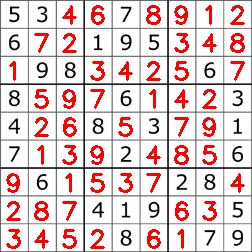

In [169]:
# solve
from prettytable import PrettyTable as pt 
sgrid=pt()
count=0
from copy import deepcopy as snap
from pprint import PrettyPrinter 
pp =PrettyPrinter()
def check_row_column(x,y,temp_grid=grid):
    possible=[]
    ## checking all the columns
    for guess in range(1,10):
        wrong=False
        for yi in range(0,9):
            if guess == temp_grid[x][yi]:
                wrong=True
                break
        if not wrong:
            possible.append(guess)

    better=[]
    for value in possible:
        wrong=False
        for xi in range(0,9):
            if value == temp_grid[xi][y]:
                wrong=True
                break
        if not wrong:
            better.append(value)

    return better

def check_cube(x,y,temp_grid=grid,possible=[1,2,3,4,5,6,7,8,9]):
    
    topX,topY=3*(x//3),3*(y//3)
    better=[]
    for value in possible:
        wrong=False
        for x in range(topX,topX+3):
            for y in range(topY,topY+3):
                if temp_grid[x][y] == value:
                    wrong=True
                    break
            if wrong:
                break
        if not wrong:
            better.append(value)                                   
    return better

def cell_values(cell,grid=grid):
    x,y=cell
    pos=[]
    pos=check_row_column(x,y,grid)
    values =check_cube(x,y,grid,pos)
    return values



def find_empty_cells(temp_grid):
    empty_cells=[]
    for x in range(0,9): 
        for y in range (0,9):
            if  temp_grid[x][y]==0:
                empty_cells.append((x,y))
    return empty_cells

def markuper(temp_grid=grid):
    mark=[]
    cells=find_empty_cells(grid)
    for cell in cells:
        values=cell_values(cell,grid)
        mark.append([cell,values])
    return mark

def simplifier (markup):
    found=False
    for c in markup:
        cell,values=c
        if len(values)==1:
            found=True
            grid[cell[0]][cell[1]]=values[0]
                             

    if not found:
        return markup
    else:        
        return simplifier(markuper(grid))

def Valid(grid):
    count=0
    for i in range(1,10):
        for r in grid:
            for t in r:
                if i==t:
                    count+=1
        for c in range(0,9):
            if r[c]==i:

                count+=1
    if count >2:
        return False
    else:
        return True
ans=simplifier(markuper(grid))
# pp.pprint(grid)
npa = np.asarray(grid, dtype="uint8")
npa=npa.reshape((81))
npa
small_temp = small
for i in empty:
  row = i//9
  column = i -(row*9)
  y1 = row*28
  x1 = column*28
  y2 = y1+28
  
  font = cv2.FONT_HERSHEY_SIMPLEX
  number = npa[i]
  #print(i,number)
  cv2.putText(small_img,str(number),(x1+5,y2-5), font, 0.8,(0,0,255),2)
pp.pprint(grid)
cv2_imshow(small_img)

